# Identifying Volume and Volume Uncertainty of a Pit

## 0. Introduction

#### Objectives
Our primary objectives are as follows:
1. Identify the boundary of an ablated pit 
2. Measure its volume
3. Quantify volume uncertainty

#### The Catch
Our pit has been made on an imperfect natural surface and the post-ablation shape of the surface has been measured imperfectly too. These imperfections introduce two uncertainties in quantifying pit volume and associated uncertainty: 
1. Natural surface roughness
2. Measurement uncertainty

If we assume that the sample surface is ideally planar, then topographic variance away from the best-fit plane is described as a sum of surface roughness and measurement uncertainty. Quantifying this variance is the key to quanitifying volume uncertainty of the ablated pit.

## 1. Quantifying Surface Topographic Variance
First, we load the test surface data, which is an x,y,z tab-separated values list of surface coordinates. These data come from Barb Cohen (Feb 1, 2021 to Jacob).


In [57]:
import numpy as np

data = np.loadtxt('surface.tsv')
print('%d coordinate triplets loaded' % len(data))

X = data[:,0]
Y = data[:,1]
Z = data[:,2]

7191 coordinate triplets loaded


**Now plot the data points**

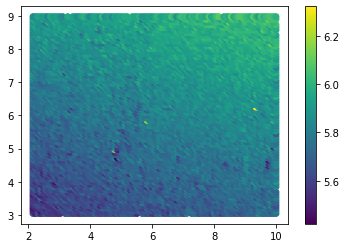

In [58]:
import matplotlib.pyplot as plt

plt.scatter(X,Y,c=Z)
plt.colorbar()
plt.show()

**The surface topography grades across the map**. We reduce this by fitting a plane to the data and subtracting this from the data.

To model a plane we will compute the least squares solution to Ax=b where A is the coordinate matrix and b is the surface height matrix.

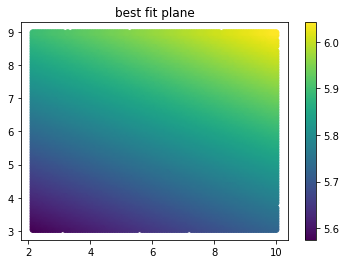

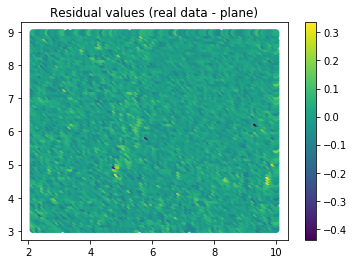

In [59]:
import scipy.linalg as la

#First Concatenate the left side of the equation (Ax)
A = np.c_[X,Y,np.ones(len(data))]

#perform least squares inversion, keep the coefficients, ignore 3 other outputs
Coeffs,_,_,_ = la.lstsq(A,Z)

#Check it on the same coordinates
Z_plane = Coeffs[0]*X + Coeffs[1]*Y + Coeffs[2]
Z_residual = Z_plane - Z

plt.clf()
plt.scatter(X,Y,c=Z_plane)
plt.colorbar()
plt.title('best fit plane')
plt.show()

plt.clf()
plt.scatter(X,Y,c=Z_residual)
plt.colorbar()
plt.title('Residual values (real data - plane)')
plt.show()

**Statistics can now be performed to characterize the topographic variance**
Additionally, we can draw a profile to see the variance of the data

The mean residual value should be close to 0. In reality, it is:   0.000000
The standard deviation of the residual is: 0.045715
90%, 95%, and 99% of the residual lies within: 0.072237, 0.090241, 0.128833 of the mean value


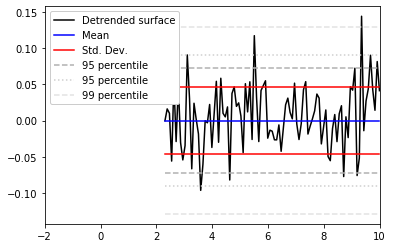

In [60]:
resid_mean = np.mean(Z_residual)
resid_std =  np.std(Z_residual)
abs_resid_90 = np.percentile(np.abs(Z_residual),90)
abs_resid_95 = np.percentile(np.abs(Z_residual),95)
abs_resid_99 = np.percentile(np.abs(Z_residual),99)

print("The mean residual value should be close to 0. In reality, it is:   %0.6f" % resid_mean)
print("The standard deviation of the residual is: %0.6f" % resid_std)
print("90%%, 95%%, and 99%% of the residual lies within: %0.6f, %0.6f, %0.6f of the mean value" % (abs_resid_90, \
                                                                                               abs_resid_95, \
                                                                                               abs_resid_99))

#Lets plot this all up along with a data profile across the center of the plotted data above
profile_Z = Z_residual[np.where(Y==np.median(Y))]
profile_X = X[np.where(Y==np.median(Y))]
prof_mean = np.ones(len(profile_Z))*resid_mean
tprof_std = np.ones(len(profile_Z))*resid_std   + resid_mean 
tprof_90 = np.ones(len(profile_Z))*abs_resid_90 + resid_mean 
tprof_95 = np.ones(len(profile_Z))*abs_resid_95 + resid_mean 
tprof_99 = np.ones(len(profile_Z))*abs_resid_99 + resid_mean 
bprof_std = np.ones(len(profile_Z))*-1*resid_std   + resid_mean 
bprof_90 = np.ones(len(profile_Z))*-1*abs_resid_90 + resid_mean 
bprof_95 = np.ones(len(profile_Z))*-1*abs_resid_95 + resid_mean 
bprof_99 = np.ones(len(profile_Z))*-1*abs_resid_99 + resid_mean 

plt.plot(profile_X,profile_Z,c='k',label='Detrended surface')
plt.plot(profile_X,prof_mean,c='b',label='Mean')
plt.plot(profile_X,tprof_std,c='r',label='Std. Dev.')
plt.plot(profile_X,tprof_90,c='80',ls='dashed')
plt.plot(profile_X,tprof_95,c='50',ls='dotted')
plt.plot(profile_X,tprof_99,c='30',ls='dashed')
plt.plot(profile_X,bprof_std,c='r')
plt.plot(profile_X,bprof_90,c='80',ls='dashed',label='95 percentile')
plt.plot(profile_X,bprof_95,c='50',ls='dotted',label='95 percentile')
plt.plot(profile_X,bprof_99,c='30',ls='dashed',label='99 percentile')
plt.legend(loc='upper left',framealpha=1)
plt.xlim([-2,10]) #to show both data and legend
plt.show()

## 2. Uncertainty Propagation

Variance at any coordinate considered to be independent and normally distributed (e.g., random along a gaussian distribution). The mean and standard deviation that describe the normal distribution are calculated in the previous step. 

*Here we will accept the standard deviation as the intrinsic uncertainty of the data, which is a combination of surface roughness and measurement uncertainty*

#### If an entire region of the detrended surface is assumed to have a constant mean elevation, what is the expected volume error?

**Volume = Area x Height**

In this case, Area is the product of the x and y spacing and Height is the integrated elevation of coordinate triplet.

**Volume Uncertainty = Area x Total Height Uncertainty**

Uncertainty from adding independent quantities propogates as a quadrature sum. This is explored with the profile data from the above chart

In [61]:
x_step = 0.0801
y_step = 0.0801

x_cells = len(profile_Z)
y_cells = 1

total_cells = x_cells*y_cells

#Make an array, the same size as the cells in question, and make all array values = the standard deviation
single_cell_uncertainties = np.ones(total_cells) * resid_std

#Add these uncertantites in quadrature 
height_uncertainty = np.sum(single_cell_uncertainties**2)**0.5

#Multiply the height uncertainty by the grid cell area to get volume
volume_uncertainty = x_step * y_step * height_uncertainty

print('Over the %d cells in the profile, total volume uncertainty is +/- %0.6f cu. units.' % (total_cells,volume_uncertainty))

Over the 94 cells in the profile, total volume uncertainty is +/- 0.002844 cu. units.


### Results

While the actual error won't be exactly equivalent to the estimated uncertainty, the actual error should be within the estimated uncertainty (i.e., <100%) about 68% of the time, assuming the uncertainties really are normally distributed. By extension, the data should be within 200% of the estimated uncertainty 95% of the time, representing the 2-standard deviation threshold.

In [62]:
volume_expected = x_step* y_step * total_cells * resid_mean
print('The expected volume over the profile subsample, assuming a mean elevation is: %0.6f cu. units' % volume_expected)

volume_observed = x_step * y_step * np.sum(profile_Z)
print('The observed volume of the subsample is: %0.6f cu. units' % volume_observed)

volume_error_comparison = abs(volume_observed - volume_expected)/volume_uncertainty
print('The actual error is %0.3f%% of the estimated uncertainty' % (volume_error_comparison*100))

The expected volume over the profile subsample, assuming a mean elevation is: 0.000000 cu. units
The observed volume of the subsample is: 0.003786 cu. units
The actual error is 133.151% of the estimated uncertainty


### Summary
This section performed the following analysis on a coordinate dataset
1. Visualized the data
2. Identified a best fit plane to the data
3. Detrended this plane from the dataset
4. Analyzed the variance of the detrended data
5. Estimated the volume uncertainty of a segment of the dataset
6. Measured the volume of the same data segment.

## 3. Identifying a pit

OpenCV can be used to identify a pit on a regular gridded raster dataset

A pit can be defined as a contiguous collection of points that are below (by some threshold, perhaps 1 sigma) below the mean value

### Load Pit Data
Pit data is loaded using the CSV format constructed in the Jupyter Notebook `Loading Height Data`. First metadata is captured, followed by the actual data.

**Metadata**

In [63]:
filename = 'data/FC3_P17_keyence.csv'

with open(filename) as kf:
    line = kf.readline()
    count = 0
    while line:
        linestr = line.split(':')
        metadata_field = linestr[0]
        if 'x interval' in metadata_field:
            xRes      = float(linestr[1])
        elif 'y interval' in metadata_field:
            yRes      = float(linestr[1])
        elif 'vertical resolution' in metadata_field:
            zRes      = float(linestr[1])
        elif 'rows' in metadata_field:
            rows      = int(linestr[1])
        elif 'columns' in metadata_field:
            cols      = int(linestr[1])
        elif 'Units' in metadata_field:
            units     = linestr[1].strip()
        count += 1
        line = kf.readline()#.strip()

print('x,y resolutions: %0.6f %0.6f' % (xRes,yRes))
print('z resolution: %0.6f' % zRes)
print('rows, columns: %d, %d' % (rows,cols))
print('units: %s' % units)

entries = rows*cols

header_lines = count - entries
print('The entire file has %d lines, %d of which are header lines' % (count,header_lines))

x,y resolutions: 0.694430 0.694430
z resolution: 0.000100
rows, columns: 768, 1024
units: um
The entire file has 786441 lines, 9 of which are header lines


**Data**

In [64]:
# Import the actual data
import numpy as np

csv_data = np.loadtxt(filename,skiprows=header_lines,delimiter=',')

x_data = csv_data[:,0]
y_data = csv_data[:,1]
z_data = csv_data[:,2]

#reshape the data into row x column arrays
XX = x_data.reshape(rows,cols)
YY = y_data.reshape(rows,cols)
ZZ = z_data.reshape(rows,cols)

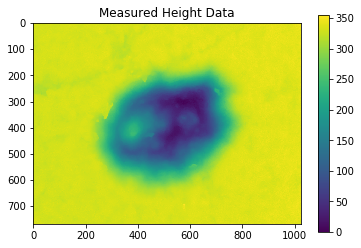

In [65]:
# Plot the data

plt.clf()
plt.imshow(ZZ)
plt.title('Measured Height Data')
plt.colorbar()
plt.show()

### Detrend the data while avoiding the pit

To estimate vertical uncertainty, it is important to separate the naturally rough surface from the anthropogenically created pit. There are multiple avenues to do this:

1. Make a safe guess of a rectangular or circular region in the map to ignore when performing the best-fit-plane calculation. **Pro.** Easy - just ignore all but the perimeter of the data. **Cons.** Probably throwing away too much data before the planar detrend. Different pits might require different guesses. 
2. Make a first guess of the pit to ignore in the best-fit-plane calculation. **Pro.** Preserves more pit-exterior data if the pit estimate is good. **Con.** Difficult to do automatically if the data has a high slope.
3. Just perform the best-fit plane calculation with all the data. **Pro.** The easiest method. No masking needed. **Con.** While this might work if the pit is well centered and symmetrical, the result will be increasingly unreliable with non-ideally situated pits.

As the pit depth is much greater than the slope in this example, method #2 will be attempted. First, to understand where the pit 'is', a histogram of the measured heights will be generated.

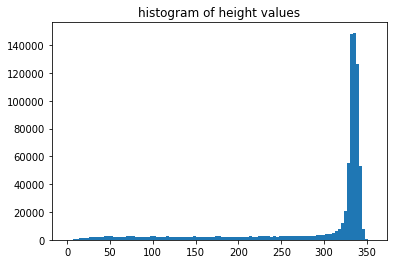

In [66]:
#make a very large number of bins for the histogram
bins = np.linspace(np.min(z_data),np.max(z_data),100)

#Plot the CDF
plt.clf()
plt.hist(z_data, bins=bins)
plt.title('histogram of height values')
plt.show()

Most of the height data in the above graphic is between 325 and 350 um in height. This represents the surface of the sample, with lower values representing pit locations. Discarding lower values will provide a pit-less surface to perform the best-fit-plane calculation on.

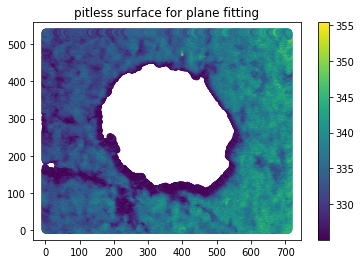

In [67]:
#Get just the non-pit values
pit_margin_first_guess = 325
surf_xs = x_data[np.where(z_data>pit_margin_first_guess)]
surf_ys = y_data[np.where(z_data>pit_margin_first_guess)]
surf_zs = z_data[np.where(z_data>pit_margin_first_guess)]

#Plot this data subset
plt.clf()
plt.scatter(surf_xs,surf_ys,c=surf_zs)
plt.title('pitless surface for plane fitting')
plt.colorbar()
plt.show()

The margin around the masked data is still obviously lower than the surface, but this first cut will help make a good best-fit plane that is not affected by nearly any of the pit. Note to the left, small parts of the pit-exterior data have been masked, illustrating the potentially large setbacks of this method.

### Fit the plane
Using the same method in the first section, a plane will be fit to this masked data.

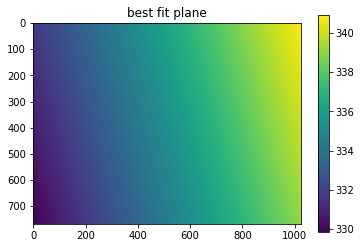

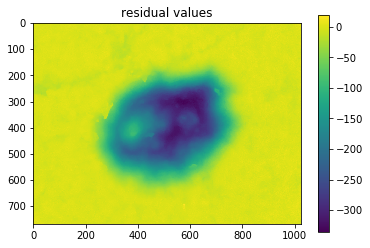

In [68]:
#First Concatenate the left side of the equation (Ax)
pitA = np.c_[surf_xs,surf_ys,np.ones(len(surf_xs))]

#perform least squares inversion, keep the coefficients, ignore 3 other outputs
Coeffs,_,_,_ = la.lstsq(pitA,surf_zs)

#Now calculate the plane on ALL sample locations, not just the mask!
#In this case, we'll use the gridded XX,YY,ZZ data
PP = Coeffs[0]*XX + Coeffs[1]*YY + Coeffs[2]
ZZ_resid = ZZ - PP

# plot with imshow
plt.clf()
plt.imshow(PP)
plt.colorbar()
plt.title('best fit plane')
plt.show()

plt.clf()
plt.imshow(ZZ_resid)
plt.colorbar()
plt.title('residual values')
plt.show()

On this low-sloped example where the gradient has a net 10 um vertical relief across the surface, there is not much change.

### Quantifying uncertainty of the surface

This step, like the previous step, requires masking to avoid including the pit in the analysis. In this case though, the perimeter of the pit can significantly effect the quantified variance of the surface. Therefore, instead of performing a *'z mask'*, a rectangular mask will remove the pit.

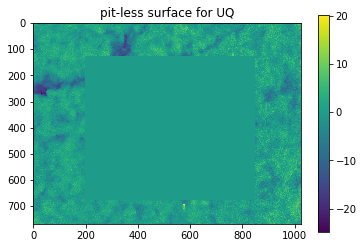

In [69]:
#First construct a boolean grid the same size as the ZZ array
#numpy ones will make all values "True"
mask = np.ones(np.shape(ZZ_resid), dtype=bool)

#Define an interior slice of the array as False
mask[125:675,200:850] = False

ZZ_mask = ZZ_resid * mask

plt.clf()
plt.imshow(ZZ_mask)
plt.title('pit-less surface for UQ')
plt.colorbar()
plt.show()

The rectangular mask is set to rows 125-675 and columns 200-800. This was found manually by guess-and-check, so it is not fully automated and objective. However, assuming the sample is acceptibly homogenous, it is not necessary to capture the entire surface to quantify uncertainty, just a large enough area. To check this, it would be possible to take several non-pit areas and compare their individual variances to identify the necessary region size to quantify variance.

With this mask, we can now identify the variance as a standard deviation from the mean surface height.

In [70]:
#This makes a list of Z values not masked out
ZZ_surfonly = ZZ_resid[np.where(mask)]

Z_res_mean = np.mean(ZZ_surfonly)
Z_res_std =  np.std(ZZ_surfonly)

print('The mean height is %0.6f um' % Z_res_mean)
print('The standard deviation of height is %0.6f um' % Z_res_std)

The mean height is 0.225502 um
The standard deviation of height is 3.238892 um


The expected mean height is >0 because the best-fit plane included some pit elevations, which are now absent in this mask. This is fine, because a constant height value does not change pit volume and is unrelated to surface slope. *Think* `y=mx+b` *where m is the slope and b is the unrelated constant height/y-intercept value.*

### Define the pit

Now with this variance data, we can define the pit as some amount of depth below the mean surface. This can use a percentile, a standard deviation, or anything else deemed important. Because standard deviation was just calculated, we will define pits as anything below 2 standard deviations below the mean. The largest of these pits will be 'The Pit'.

Anomalously low locations are anywhere below -6.252281 um


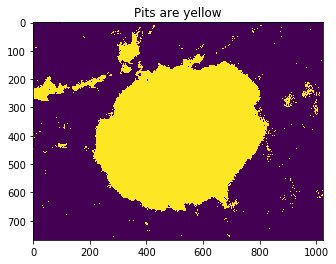

In [71]:
#Define the contour below which values represent pits
pitContour = Z_res_mean - 2*Z_res_std
print('Anomalously low locations are anywhere below %0.6f um' % pitContour)

#make a boolean pit map. Set all values to false (not a pit) with np zeros
pitmap = np.zeros(np.shape(ZZ_resid), dtype=bool)

#Anywhere where the residual Z value is less than the pit contour is a pit
pitmap[np.where(ZZ_resid<pitContour)] = True

plt.clf()
plt.imshow(pitmap)
plt.title('Pits are yellow')
plt.show()

The largest pit might be obvious to you. Python can identify it with `OpenCV`, which is a raster analysis module. 

If you are interested in *more* than just the largest pit, and also want to only accept mostly convex or circular pits, check out the documentation here: https://learnopencv.com/blob-detection-using-opencv-python-c/

# To Be Continued....

In [72]:
'''
import cv2

# Read image
#im = cv2.imread("blob.jpg", cv2.IMREAD_GRAYSCALE)

# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector()
# Detect blobs.
keypoints = detector.detect(pitmap)
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)
'''


'\nimport cv2\n\n# Read image\n#im = cv2.imread("blob.jpg", cv2.IMREAD_GRAYSCALE)\n\n# Set up the detector with default parameters.\ndetector = cv2.SimpleBlobDetector()\n# Detect blobs.\nkeypoints = detector.detect(pitmap)\n# Draw detected blobs as red circles.\n# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob\nim_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\n \n# Show keypoints\ncv2.imshow("Keypoints", im_with_keypoints)\ncv2.waitKey(0)\n'